In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

sns.set()

from IPython.display import display
from tools import make_track, ols_regression, make_ER, lasso_regression, lasso_regression_ic, ridge_regression, kalman_filter
from hc_graph import hc_stock

<IPython.core.display.Javascript object>

Open console to check js libs were loaded in page


In [3]:
fund_name = 'NEIXCTAT'
pd.read_csv(r"financial_data/hfrx_index_names.csv", index_col=0)

,Full Name
Name,
HFRXAR,HFRX Absolute Return Index
HFRXDS,HFRX ED: Distressed Restructuring Index
HFRXMA,HFRX ED: Merger Arbitrage Index
HFRXSS,HFRX ED: Special Situations Index
HFRXEMN,HFRX EH: Equity Market Neutral Index
HFRXEHG,HFRX EH: Fundamental Growth Index
HFRXEHV,HFRX EH: Fundamental Value Index
HFRXEMC,HFRX Emerging Markets Composite Index
HFRXEWC,HFRX Equal Weighted Strategies CHF Index


In [4]:
pd.options.display.max_rows = 76
pd.read_csv(r"financial_data/bnp_index_info.csv", index_col=0)

,Name,Asset Class,Underlying,Currency,Execution Costs (bps),Replication Costs (bps)
Ticker,,,,,,
BNPIFEU,Eurozone Equity,Equity,Eurostoxx 50,EUR,3,12
BNPIFUS,US Equity,Equity,S&P 500,USD,3,12
BNPIFJP,Japan Equity,Equity,Nikkei,JPY,3,12
BNPIFCN,China Equity,Equity,HSCEI,HKD,3,12
BNPIFFR,France Equity,Equity,CAC 40,EUR,3,12
BNPIFGE,Germany Equity,Equity,Dax,EUR,3,12
BNPIFGB,Great Britain Equity,Equity,FTSE 100,GBP,3,12
BNPIFCH,Swiss Equity,Equity,SMI,CHF,3,12
BNPIFKR,Korea Equity,Equity,Kospi,KRW,3,12


In [5]:
pd.read_csv(r"financial_data/bnp_risk_premia_info.csv", index_col=0)

,Name,Asset class,Style,Return Type,Currency
Ticker,,,,,
BNPIDRXA,BNP Paribas DR Alpha ex-Agriculture and Livest...,Commodities,Carry,ER,EUR
BNPIF3AX,BNP Paribas Alpha Backwardation ex-Agriculture...,Commodities,Carry,ER,EUR
BNPIF3XM,BNP Paribas Alpha Momentum ex-Agriculture and ...,Commodities,Momentum,ER,EUR
BPFXSTGU,BNP Paribas 1M STEER Index,FX,Value,ER,EUR
BNPICCE3,BNP Paribas 103 Call Carry Excess Return Index,Equity,Carry,ER,EUR
BNPIVMRU,BNP Paribas Volatility Mean Reversion US,Equity,Reversal,ER,EUR
BPCURVW4,BNP Paribas Money Market Beta World Index,IR,Carry,ER,EUR
BNPIVCXA,BNP Paribas Commodity Short Variance VCXA ER I...,Commodities,Short Variance,ER,EUR
BNPIAIRT,BNP Paribas AIR T-Note ER Index,Equity,Volatility,ER,EUR


### Financial data loads and cleaning

In [6]:
# US rate
US_rate = pd.read_csv(r"financial_data/USD_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['3M']

# HFRX
hfrx_all = pd.read_csv(r"financial_data/hfrx_daily_index_data.csv", index_col=0, parse_dates=True, dayfirst=True).ffill()
hfrx = make_ER(hfrx_all[[fund_name]].dropna(), US_rate)

# BNP

bnp = pd.read_csv(r"financial_data/bnp_data.csv", index_col=0, parse_dates=True, dayfirst=True) #[["BNPIFEU","BNPIFUS",
                 #"BNPIFJP","BNPIFCN","BNPIFFR","BNPIFGE","BNPIFGB","BNPIFCH","BNPIFKR","BNPIFUSC","BNPIFBR",
                 #"BNPIFAU","BNPIFHK","BNPIFTW","BNPIFSG","BNPIFIT","BNPIFSP","BNPIFSW","BNPIFNE","BNPIFRU","BNPIFEM"]]

risk_premia = pd.read_pickle("financial_data/risk_premia_ER_FX_USD.pkl") #[["BNPICCE3","BNPIVMRU","BNPIAIRT","BNPIAIRU",
                  #"BNPIEC03","BNPIPLEE","BNPIPMEE","BNPIPQEE","BNPIPVEE","BNPILUEE","BNPIPMUH","BNPIPQUH",
                  #"BNPIPVUH","BNPIAIRG","BNPIAIRJ","BNPIAIRE"]]

In [7]:
prices_all = bnp.join(risk_premia,how="outer").ffill().bfill().join(hfrx,how="inner")

In [8]:
returns_all = prices_all.resample('1D').first().pct_change().dropna()
hrfx_returns = returns_all[[fund_name]]
returns_all = returns_all.drop(fund_name, axis=1)

In [9]:
alpha = hrfx_returns[fund_name].autocorr(lag=1)
hrfx_returns_adj = ((hrfx_returns - alpha * hrfx_returns.shift(1)) / (1. - alpha)).fillna(0) # 'liquidity adjustment' for
                                                                                             # removing returns autocorrelation
beta = hrfx_returns_adj[fund_name].autocorr(lag=1)

Auto-correlation of NEIXCTAT returns : 0.0898860933795
Auto-correlation of NEIXCTAT adjusted returns : -0.000126064706782


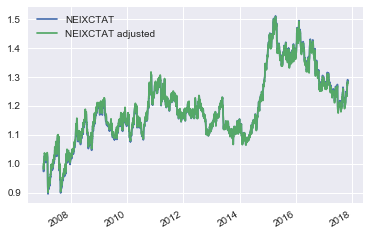

In [10]:
print("Auto-correlation of",fund_name,"returns :", alpha)
print("Auto-correlation of",fund_name,"adjusted returns :", beta)
ax = (1 + hrfx_returns).cumprod().plot()
_ = (1 + hrfx_returns_adj).cumprod()[fund_name].plot(label=fund_name + ' adjusted', legend=True, ax=ax)

In [11]:
size = 126
freq = 5
tc = 0.001
lag = 1

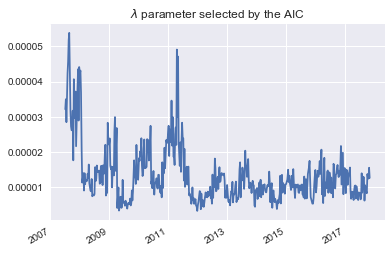

Wall time: 39.4 s


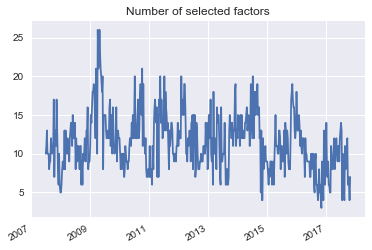

In [12]:
%%time
df_weight_aic, _ = lasso_regression_ic(hrfx_returns, returns_all,sample_length=size, frequency=freq, criterion='aic')
prices_for_track_all = prices_all.loc[df_weight_aic.index[0]:].drop(fund_name, axis=1)
replication_all = make_track(prices_for_track_all, df_weight_aic, tc=tc, lag=lag)

df_res = prices_all.loc[replication_all.index][[fund_name]]
df_res["Lasso AIC"] = replication_all
(df_weight_aic != 0).sum(axis=1).plot(title='Number of selected factors')

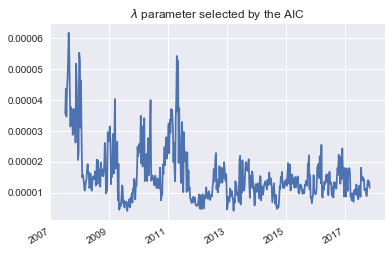

Wall time: 39.2 s


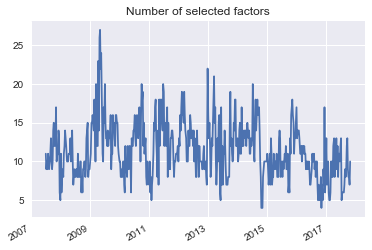

In [13]:
%%time
df_weight_aic_adj, _ = lasso_regression_ic(hrfx_returns_adj, returns_all,sample_length=size, frequency=freq, criterion='aic')
prices_for_track_all = prices_all.loc[df_weight_aic_adj.index[0]:].drop(fund_name, axis=1)
replication_all = make_track(prices_for_track_all, df_weight_aic_adj, tc=tc, lag=lag)

df_res["Lasso AIC adjusted"] = replication_all
(df_weight_aic_adj != 0).sum(axis=1).plot(title='Number of selected factors')

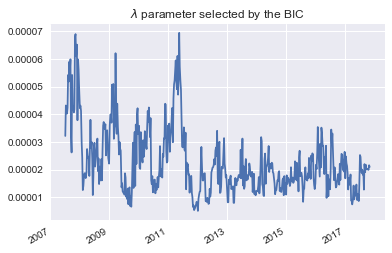

Wall time: 39 s


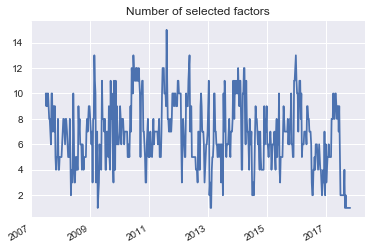

In [14]:
%%time
df_weight_bic, _ = lasso_regression_ic(hrfx_returns, returns_all,sample_length=size, frequency=freq, criterion='bic')
prices_for_track_all = prices_all.loc[df_weight_bic.index[0]:].drop(fund_name, axis=1)
replication_all = make_track(prices_for_track_all, df_weight_bic, tc=tc, lag=lag)

df_res["Lasso BIC"] = replication_all
(df_weight_bic != 0).sum(axis=1).plot(title='Number of selected factors')

In [15]:
%%time
nu = 1.
df_weight_kalman = kalman_filter(hrfx_returns, returns_all,freq, sigma_weight=nu*0.1 , sigma_return=0.1)

prices_for_track_kalman = prices_all.loc[df_weight_kalman.index[0]:]
replication_kalman = make_track(prices_for_track_kalman, df_weight_kalman, tc=tc, lag=lag).loc[df_res.index[0]:]
df_res["Kalman"] = replication_kalman

Wall time: 9.78 s


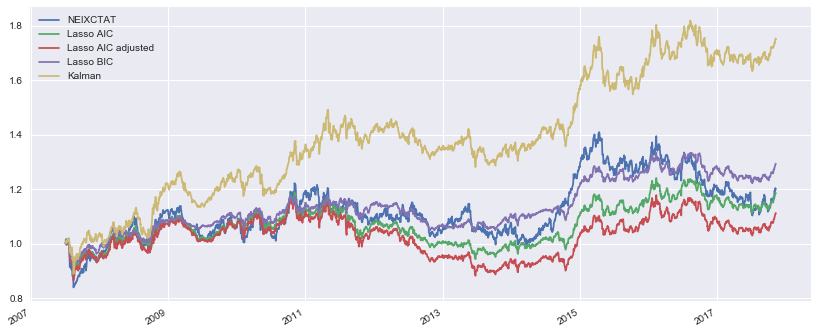

In [16]:
df_res = (df_res / df_res.iloc[0])
df_res.plot(figsize=(14,6))

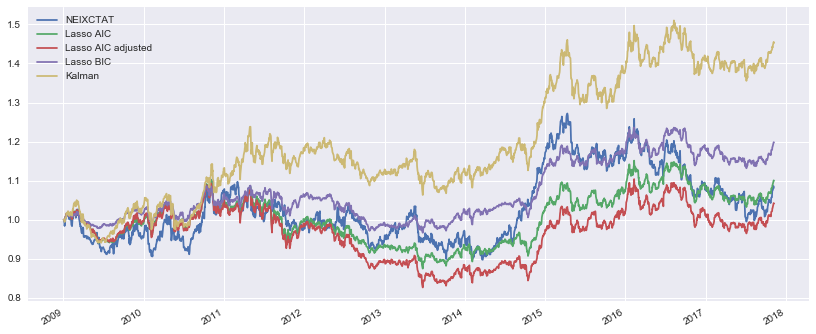

In [17]:
df_res2 = df_res.loc["2009":]
df_res2 = (df_res2 / df_res2.iloc[0])
df_res2.plot(figsize=(14,6))

In [18]:
df_res.pct_change().corr(method="pearson")

,NEIXCTAT,Lasso AIC,Lasso AIC adjusted,Lasso BIC,Kalman
NEIXCTAT,1.000000,0.724618,0.720482,0.689163,0.764842
Lasso AIC,0.724618,1.000000,0.990946,0.960163,0.897683
Lasso AIC adjusted,0.720482,0.990946,1.000000,0.962936,0.895730
Lasso BIC,0.689163,0.960163,0.962936,1.000000,0.855106
Kalman,0.764842,0.897683,0.895730,0.855106,1.000000


In [19]:
returns_track = df_res.pct_change().dropna()
feu = returns_track[fund_name]
returns_track = returns_track.drop(fund_name, axis=1)
df = pd.DataFrame()
df['Tracking error'] = (returns_track.T - feu.values).std(axis=1)
df['R-squared'] = 1 - (returns_track.T - feu.values).var(axis=1) / feu.values.var()
df

,Tracking error,R-squared
Lasso AIC,0.004922,0.524044
Lasso AIC adjusted,0.004956,0.517405
Lasso BIC,0.005249,0.458553
Kalman,0.004633,0.578221


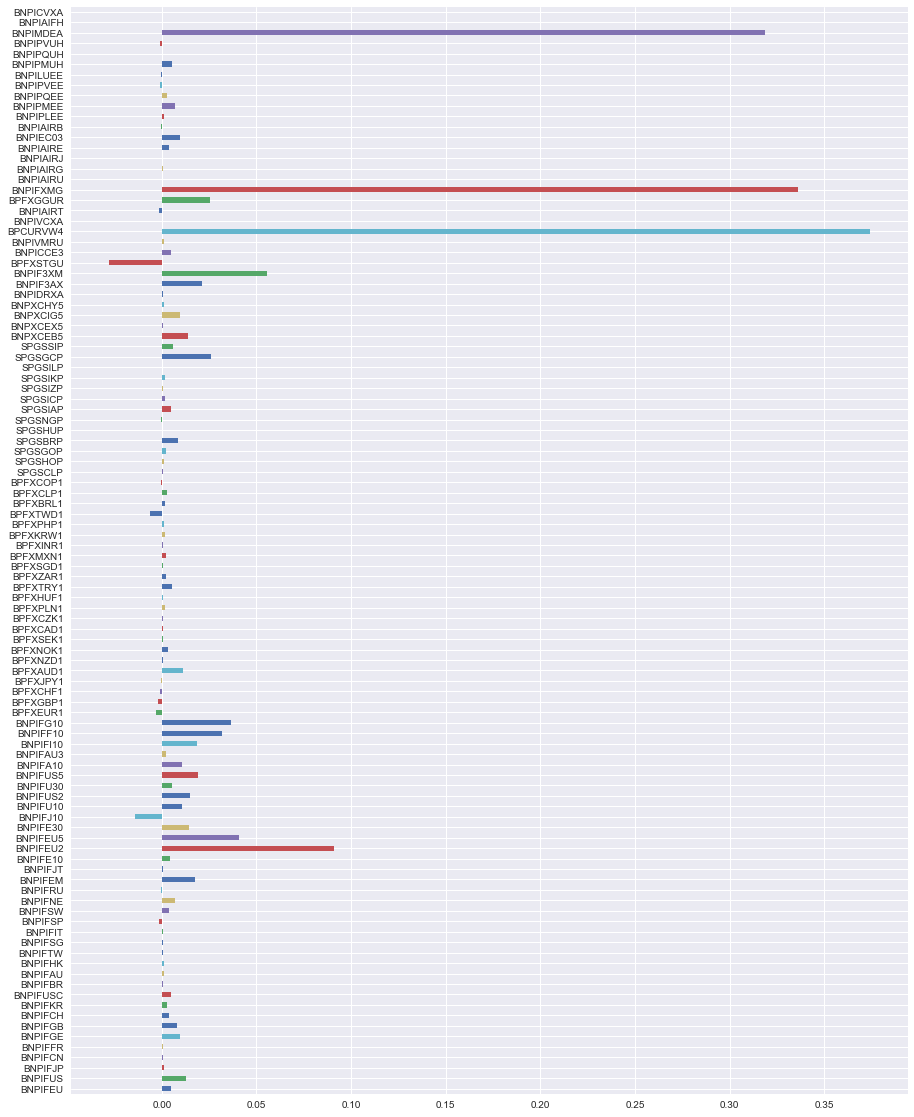

In [20]:
(df_weight_aic).mean(axis=0).plot(kind='barh', figsize=(15,20))

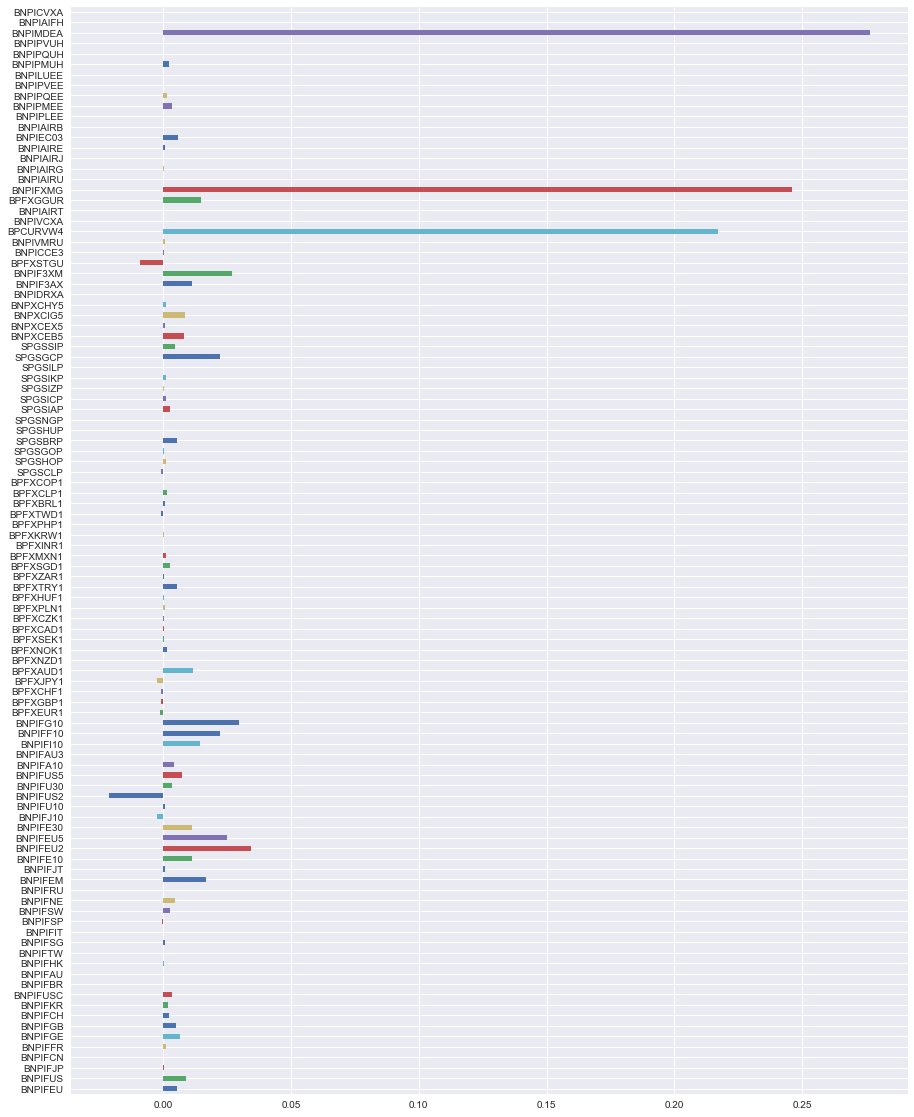

In [21]:
(df_weight_bic).mean(axis=0).plot(kind='barh', figsize=(15,20))

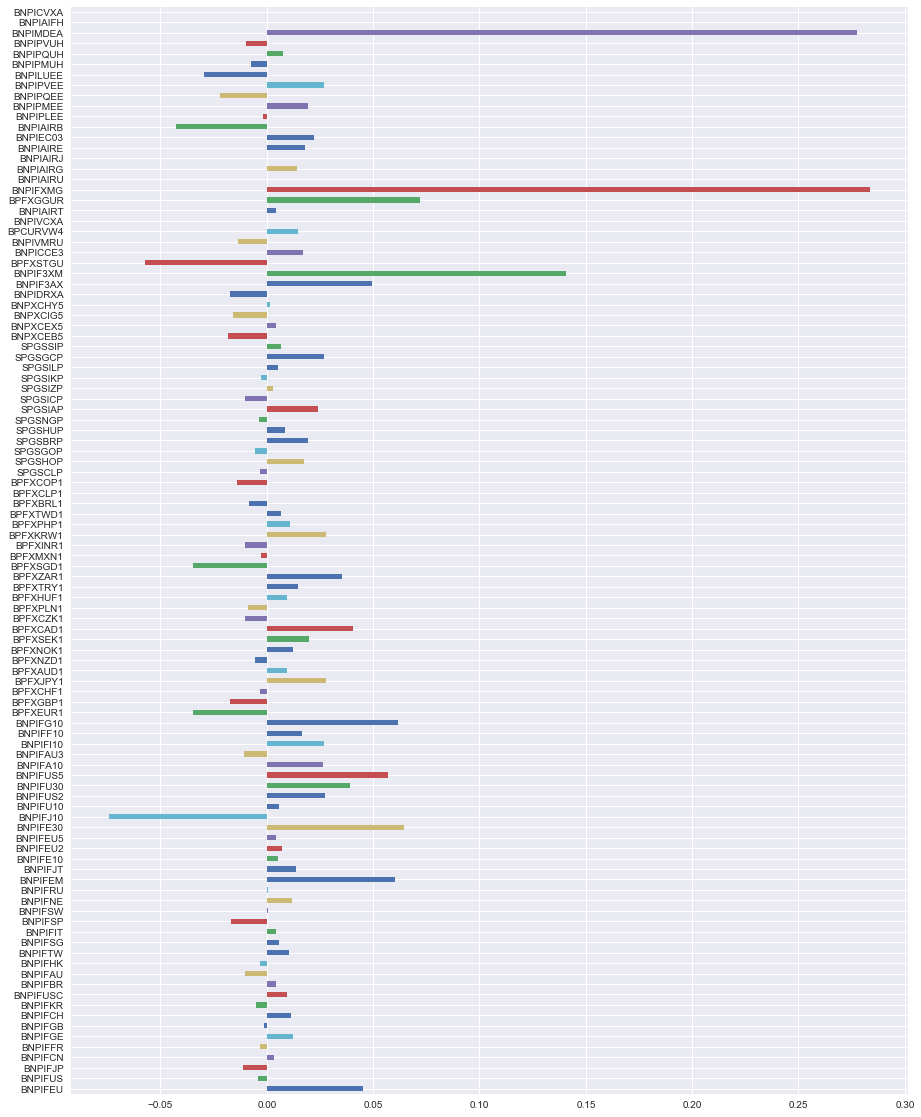

In [22]:
df_weight_kalman.loc[df_res.index[0]:].mean(axis=0).plot(kind='barh', figsize=(15,20))

In [23]:
df_res[fund_name].pct_change().autocorr(lag=1)

0.074615512211802515

In [24]:
df_res['Kalman'].pct_change().autocorr(lag=1)

0.095859282491289624

In [25]:
df_res['Lasso AIC'].pct_change().autocorr(lag=1)

0.088218522446570607

In [26]:
df_res['Lasso AIC adjusted'].pct_change().autocorr(lag=1)

0.078814405645598204